# Linear Regression

The prediction task: to predict the amount of calories in Starbucks’ drinks based on the other available nutritional data.

First, we will do the prediction based on just one variable (*simple regression*) and then will expand to all potentially relevant variables (*multiple regression*). 

### Load the required modules

In [49]:
from pathlib import Path

from statistics import mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from LR_diagnostics import LinearRegDiagnostic

### Load and inspect the data

The data originates from the [Starbucks menu data set](https://www.kaggle.com/datasets/starbucks/starbucks-menu). It has been adapted for this class.

In [50]:
starbucks = pd.read_csv(Path.cwd() / 'data' / 'starbucks_calories.csv')
starbucks.head(50)

,drink_id,beverage,calories,fat_tot,carbohydrates_tot,sugar,proteins
0,1,Brewed Coffee (Short),3,0.1,5,0,0.3
1,2,Brewed Coffee (Tall),4,0.1,10,0,0.5
2,3,Brewed Coffee (Grande),5,0.1,10,0,1.0
3,4,Brewed Coffee (Venti),5,0.1,10,0,1.0
4,5,Caffè Latte (Short Nonfat Milk),70,0.1,75,9,6.0
5,6,Caffè Latte (2% Milk),100,3.5,85,9,6.0
6,7,Caffè Latte (Soymilk),70,2.5,65,4,5.0
7,8,Caffè Latte (Tall Nonfat Milk),100,0.2,120,14,10.0
8,9,Caffè Latte (2% Milk),150,6.0,135,14,10.0
9,10,Caffè Latte (Soymilk),110,4.5,105,6,8.0


In [51]:
starbucks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   drink_id           241 non-null    int64  
 1   beverage           241 non-null    object 
 2   calories           241 non-null    int64  
 3   fat_tot            241 non-null    float64
 4   carbohydrates_tot  241 non-null    int64  
 5   sugar              241 non-null    int64  
 6   proteins           241 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 13.3+ KB


### Examining relationships among the variables

To identify variables that might be relevant for building a prediction model, we will examine correlations between the outcome variable (calories) and other variables in the data set that may serve as predictors.

To that end, we will, first, select numerical variables that are meaningful for predicting the outcome (calories) and then compute and plot correlations: 

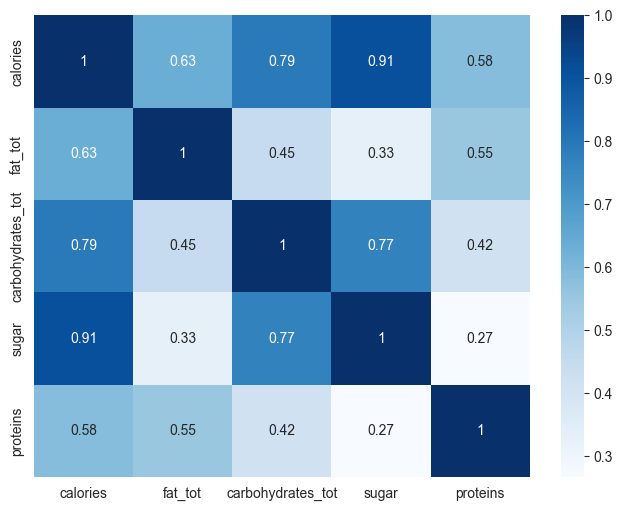

In [52]:
# Select variables 
stb_sub = starbucks.iloc[:, 2:]

# Compute correlations
stb_cor = stb_sub.corr(method="pearson")

# Present them visually
plt.figure(figsize=(8,6))
sb.heatmap(stb_cor, cmap="Blues",annot=True)
plt.show()

Clearly all variables are (moderately to highly) correlated with `calories`, but especially `sugar`. Let’s inspect the relation with `sugar` closer.

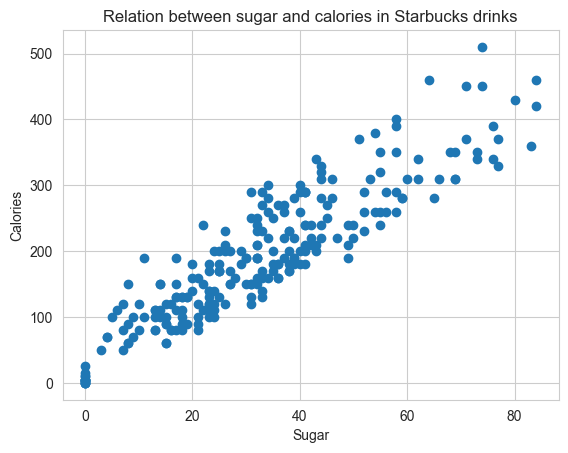

In [53]:
_, ax = plt.subplots()
ax.scatter(stb_sub.sugar, stb_sub.calories)
ax.set_title("Relation between sugar and calories in Starbucks drinks", )
ax.set_xlabel('Sugar')
ax.set_ylabel('Calories')
plt.show()

It seems that sugar and calories have fine linear relationship, thus satisfying the primary criterion for linear modeling.

### Train-test split

Before going any further, we need to split the data into training and test sets. We will build our models using training data only, while test data will be used for model evaluation only.

There are 2 key requirements when splitting the data into training and test sets: 
1) random selection of observations to go into training and test sets 
2) ensuring the same distribution of the outcome variable in both parts (train and test) 

To ensure these requirements are satisfied, we use the `train_test_split` method from the `sklearn` library, with appropriate settings for its `shuffle` and `stratify` arguments: 

In [54]:
# separate input and output variables
X = stb_sub.drop(columns="calories")
y = stb_sub.calories

# the following two lines are required for stratified split, that is, 
# to create a discretized version of the outcome variable to be used by the train_test_split method for stratified sampling
y_quantiles = np.quantile(y, [0.25, 0.5, 0.75])
quantile_labels = np.digitize(y, y_quantiles)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.75, 
                                                    random_state=1,
                                                    shuffle=True,
                                                    stratify=quantile_labels)

Check if the distribution of the `calories` variable in the train and test sets is roughly the same:

In [55]:
y_df = pd.concat([y_train, y_test], axis=1)
y_df.describe()

,calories,calories
count,180.000000,61.000000
mean,192.222222,196.672131
std,102.891468,103.126091
min,0.000000,3.000000
25%,120.000000,120.000000
50%,185.000000,180.000000
75%,260.000000,270.000000
max,510.000000,460.000000


Present it visually, as well

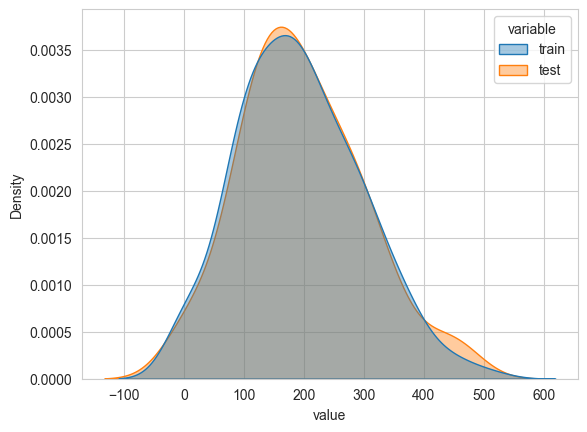

In [56]:
y_df.columns = ["train", "test"]
y_df.reset_index(drop=False, inplace=True)
y_df_long = pd.melt(y_df, id_vars='index', value_vars=['train', 'test'])

sb.kdeplot(data=y_df_long, x="value", hue="variable", fill=True, common_norm=False, alpha=0.4)
plt.show()

Not ideal but very similar

### Simple linear regression

Create a simple linear regression model with `sugar` as the only predictor:

In [57]:
X_train_simple = X_train.sugar
# we need to add a column with 1s to have the intercept included in the model
X_train_simple = sm.add_constant(X_train_simple)
# X_train_simple.head()

lm1 = sm.OLS(y_train, X_train_simple)
lm1 = lm1.fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:               calories   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     835.5
Date:                Wed, 21 May 2025   Prob (F-statistic):           3.85e-69
Time:                        11:48:27   Log-Likelihood:                -932.42
No. Observations:                 180   AIC:                             1869.
Df Residuals:                     178   BIC:                             1875.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.4608      6.368      5.254      0.0

Get the parameter estimates and the confidence interval for the estimates

In [58]:
lm1.conf_int(alpha=0.05)

,0,1
const,20.893967,46.027671
sugar,4.454015,5.106725


We would interpret this confidence interval as follows: 
in 95% of samples taken from the population of Starbucks drinks, the estimated value of the parameter associated with the `sugar` variable will be in the (4.45 to 5.11) range.

#### Diagnostic plots

Check if the assumptions for linear models are met, using the plotting methods of the `LinearRegDiagnostic` class from the `LR_diagnostics` module. 
Each method creates one diagnostic plot, as shown below.

In [59]:
lm1_rd = LinearRegDiagnostic(lm1)

The `residual_plot` method plots the residuals against fitted values; this plot is used for checking if the linearity assumption is satisfied:

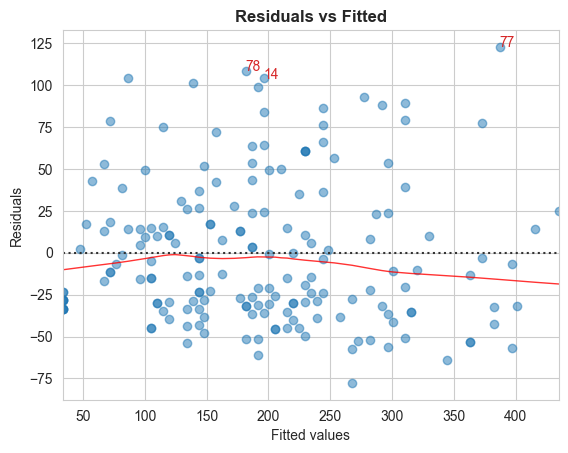

In [60]:
lm1_rd.residual_plot();

The `qq_plot` method tells us if residuals are normally distributed.

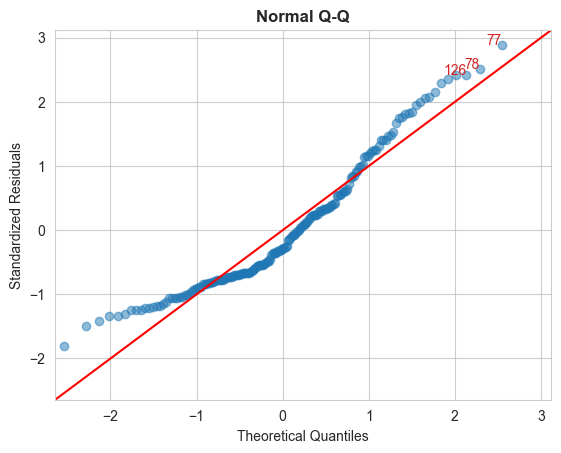

In [61]:
lm1_rd.qq_plot();

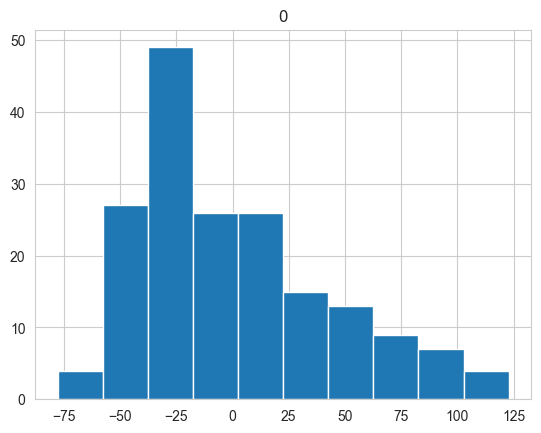

In [62]:
lm1_residuals_df = pd.DataFrame(lm1_rd.residual)
lm1_residuals_df.hist();

The `scale_location_plot` plot is used for checking the assumption - known as homoscedasticity - that the residuals have equal variance

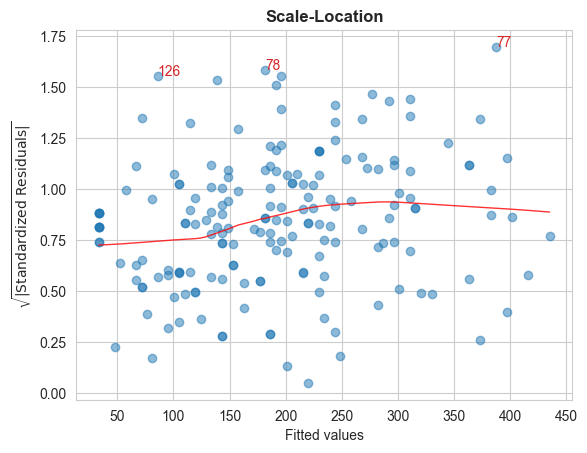

In [63]:
lm1_rd.scale_location_plot();

The `leverage_plot` plot is used for spotting the presence of highly influential observations; those are the observations that, if included in or excluded from the model, can significantly affect the values of the model parameters. Such observations are identified among those with unusually high/low output values (outliers) and/or unusually high/low predictor values (high leverage).

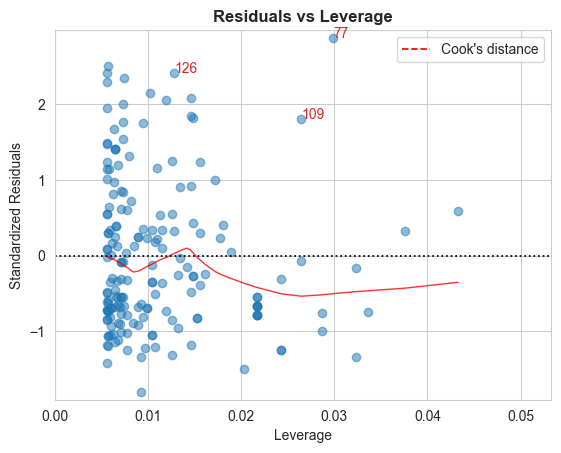

In [64]:
lm1_rd.leverage_plot();

So, out of the four assumptions, one is not properly satisfied - normality of residuals. This may affect the prediction intervals (see below), that is, lead to incorrect confidence and prediction intervals, since those intervals are calculated based on the assumption that the residuals are normally distributed.

#### Make predictions and evaluate the model on the test data

First, make predictions on the test set

In [65]:
X_test.head(10)

,fat_tot,carbohydrates_tot,sugar,proteins
26,11.0,180,43,17.0
185,3.0,220,50,3.0
5,3.5,85,9,6.0
211,4.0,250,62,5.0
7,0.2,120,14,10.0
16,1.5,60,17,7.0
237,0.1,160,38,4.0
42,0.0,15,0,1.0
191,3.0,160,40,3.0
177,1.5,120,36,15.0


In [67]:
X_test_simple = X_test.sugar.reset_index(drop=True) 
X_test_simple = sm.add_constant(X_test_simple)
# X_test_simple
lm1_pred = lm1.predict(X_test_simple)
lm1_pred

0     239.016734
1     272.479325
2      76.484150
3     329.843766
4     100.386001
         ...    
56    387.208208
57    191.213033
58    186.432663
59    119.507481
60    152.970072
Length: 61, dtype: float64

In [68]:
pred_df = pd.concat([X_test_simple.sugar, 
                     y_test.reset_index(drop=True), 
                     pd.Series(lm1_pred)], axis=1, ignore_index=True)
pred_df.columns = ['sugar', 'calories', 'calories_pred']
pred_df.head(10)

,sugar,calories,calories_pred
0,43,340,239.016734
1,50,240,272.479325
2,9,100,76.484150
3,62,310,329.843766
4,14,100,100.386001
5,17,110,114.727111
6,38,170,215.114884
7,0,15,33.460819
8,40,200,224.675624
9,36,270,205.554143


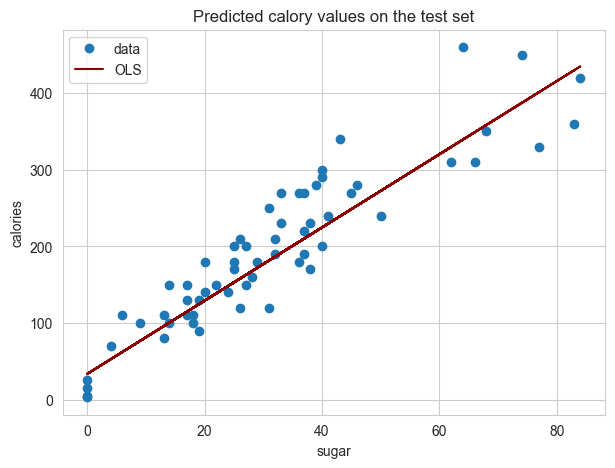

In [69]:
_, ax = plt.subplots(figsize=(7, 5))

ax.plot(pred_df.sugar, pred_df.calories, "o", label="data")
ax.plot(pred_df.sugar, pred_df.calories_pred, color='darkred', label="OLS")
ax.legend(loc="best")
ax.set_xlabel("sugar")
ax.set_ylabel("calories")
ax.set_title("Predicted calory values on the test set")
plt.show()

We can also get **confidence interval** and **prediction interval** for our predictions.
To that end, we will call the `get_prediction` method on our model in order to get access to confidence and prediction intervals: 

In [70]:
lm1_pred_details = lm1.get_prediction(X_test_simple).summary_frame()
lm1_pred_details

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,239.016734,3.606660,231.899421,246.134048,153.391273,324.642195
1,272.479325,4.253977,264.084608,280.874042,186.738234,358.220416
2,76.484150,5.139966,66.341039,86.627261,-9.445740,162.414041
3,329.843766,5.749346,318.498116,341.189417,243.763646,415.923887
4,100.386001,4.525621,91.455226,109.316775,14.590767,186.181235
...,...,...,...,...,...,...
56,387.208208,7.475993,372.455227,401.961189,300.613093,473.803322
57,191.213033,3.223114,184.852601,197.573465,105.647161,276.778905
58,186.432663,3.229143,180.060334,192.804992,100.865905,271.999420
59,119.507481,4.088453,111.439406,127.575556,33.797755,205.217208


In [71]:
# add confidence interval columns to the data frame with the predicted values 
pred_ci_df = pd.concat([pred_df, 
                        lm1_pred_details.mean_ci_lower, 
                        lm1_pred_details.mean_ci_upper], axis=1)
pred_ci_df

,sugar,calories,calories_pred,mean_ci_lower,mean_ci_upper
0,43,340,239.016734,231.899421,246.134048
1,50,240,272.479325,264.084608,280.874042
2,9,100,76.484150,66.341039,86.627261
3,62,310,329.843766,318.498116,341.189417
4,14,100,100.386001,91.455226,109.316775
...,...,...,...,...,...
56,74,450,387.208208,372.455227,401.961189
57,33,270,191.213033,184.852601,197.573465
58,32,210,186.432663,180.060334,192.804992
59,18,100,119.507481,111.439406,127.575556


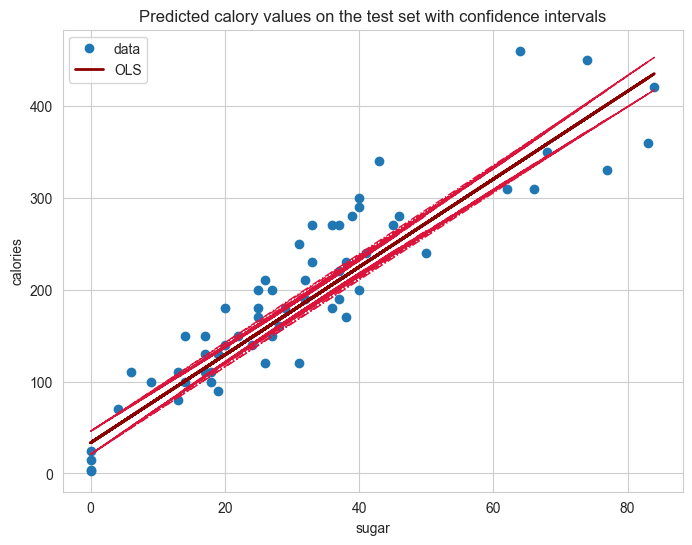

In [72]:
_, ax = plt.subplots(figsize=(8, 6))

x = pred_ci_df.sugar
ax.plot(x, pred_ci_df.calories, "o", label="data")
ax.plot(x, pred_ci_df.calories_pred, color='darkred', linewidth=2, label="OLS")
ax.plot(x, pred_ci_df.mean_ci_lower, color='crimson', linewidth=1, linestyle='dashdot')
ax.plot(x, pred_ci_df.mean_ci_upper, color='crimson', linewidth=1, linestyle='dashdot')
ax.set_xlabel("sugar")
ax.set_ylabel("calories")
ax.set_title("Predicted calory values on the test set with confidence intervals")
ax.legend(loc="best")
plt.show()

**Confidence intervals (CI)** reflect the uncertainty around the mean predictions. This uncertainty is due to the fact that we can only estimate values of the model parameters, but cannot determine the “true” or “ideal” values of those parameters. Consequently, the predictions made by our model will deviate from the predictions that the “ideal” linear model would make; this error is captured by the CI. 
For example, if we consider a CI of 95%, we can say that in 95% of drinks with 43g of sugar (see the 1st row in the table above), the expected (mean) number of calories will range between 232 and 247.

In [73]:
pred_pi_df = pd.concat([pred_df, 
                        lm1_pred_details.obs_ci_lower, 
                        lm1_pred_details.obs_ci_upper], axis=1)
pred_pi_df

,sugar,calories,calories_pred,obs_ci_lower,obs_ci_upper
0,43,340,239.016734,153.391273,324.642195
1,50,240,272.479325,186.738234,358.220416
2,9,100,76.484150,-9.445740,162.414041
3,62,310,329.843766,243.763646,415.923887
4,14,100,100.386001,14.590767,186.181235
...,...,...,...,...,...
56,74,450,387.208208,300.613093,473.803322
57,33,270,191.213033,105.647161,276.778905
58,32,210,186.432663,100.865905,271.999420
59,18,100,119.507481,33.797755,205.217208


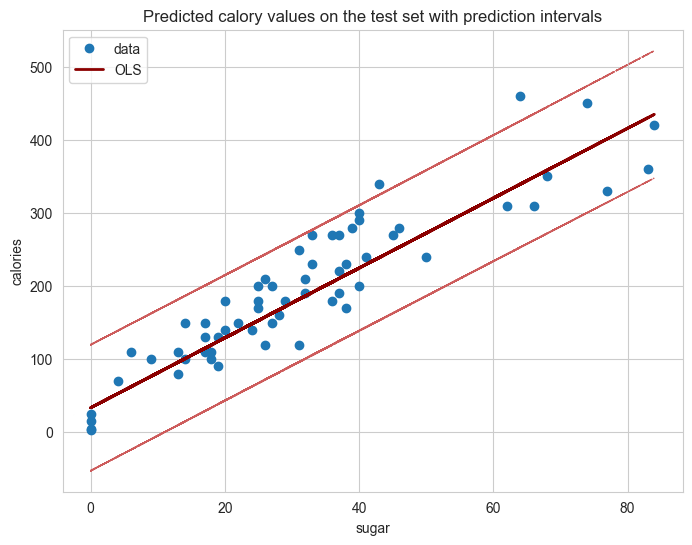

In [74]:
# prediction intervals
_, ax = plt.subplots(figsize=(8, 6))

x = pred_pi_df.sugar
ax.plot(x, pred_pi_df.calories, "o", label="data")
ax.plot(x, pred_pi_df.calories_pred, color='darkred', linewidth=2, label="OLS")
ax.plot(x, pred_pi_df.obs_ci_lower, color='indianred', linewidth=1, linestyle='dashdot')
ax.plot(x, pred_pi_df.obs_ci_upper, color='indianred', linewidth=1, linestyle='dashdot')
ax.set_xlabel("sugar")
ax.set_ylabel("calories")
ax.set_title("Predicted calory values on the test set with prediction intervals")
ax.legend(loc="best")
plt.show()

**Prediction interval (PI)** reflects uncertainty related to a particular instance. This uncertainty is due to not only the fact that we can only estimate values of the model parameters (as in case of CI), but also due to the fact that even the best linear model is just an approximation of the true relationship between the input and output variables. Hence, PI captures both the *reducible* and *irreducible* error, and thus is always wider than CI.
For example, if we consider a PI of 95%, we can say that in 95% of cases, for a particular drink with 43g of sugar, the number of calories will range between 154 and 325. 

#### Compute evaluation measures

To evaluate the model, we will compute, on the test set, two often used regression evaluation measures: R2 and RMSE

R2 is the proportion of the total variability in the dependent variable that is explained by the independent variable. It is computed as follows:
R2 = (TSS - RSS)/TSS 
where:
**TSS** stands for *Total Sum of Squares*, which is the total variability in the outcome variables (number of calories); it tells us how much the actual amount of calories in a Starbucks drink differs from the average amount.
**RSS** stands for *Residual Sum of Squares*, which measures the total squared difference between the actual amount of calories and the amount predicted by our regression model

As a simple explanation, imagine TSS as the total amount of "mess" or variability in the outcome variable we need to understand. Our regression model tries to "clean up" some of this mess. RSS represents the amount of "mess" that is still left after our model has done its best. R2 tells us what proportion of the initial "mess" we successfully cleaned up with our model.  

**RMSE** (*Root Mean Squared Error*) represents the average magnitude of the errors our model makes in predicting the outcome variable. It is computed as follows: 
RMSE = sqrt(RSS/n)
It is in the same units as the outcome variable (number of calories in our case), making it easier to interpret it.

In [75]:
def compute_eval_measures(y_train, y_test, y_pred):
    from math import sqrt
    
    tss = sum([(y_ts - mean(y_train))**2 for y_ts in y_test])
    rss = sum([(y_ts - y_pr)**2 for y_ts, y_pr in zip(y_test, y_pred)])
    r2 = (tss - rss)/tss
    
    n = len(y_test)
    rmse = sqrt(rss/n)
    
    return {'R2':r2, 'RMSE':rmse}

In [76]:
lm1_eval = compute_eval_measures(y_train, y_test, pred_df.calories_pred)
print(f"R2 = {lm1_eval['R2']:.4f}")
print(f"RMSE = {lm1_eval['RMSE']:.4f}")

R2 = 0.8299
RMSE = 42.2223


To get a perspective of how large the error is, we’ll compare it with the mean value of the outcome variable on the test set.

In [77]:
lm1_eval['RMSE']/mean(y_test) 

0.2146837076694802

It’s a fairly large error - about 22% of the average value.

### Multiple linear regression

We’ve seen that in addition to `sugar`, the other three variables are also highly correlated with `calories` (as the outcome variable). Let’s see if by adding them to the model we can get a valid model with better prediction performance.

In [78]:
X_train.head()

,fat_tot,carbohydrates_tot,sugar,proteins
156,0.1,5,31,0.4
14,9.0,220,22,16.0
215,10.0,340,84,7.0
140,5.0,125,38,9.0
126,6.0,140,46,11.0


In [79]:
X_train = sm.add_constant(X_train)

lm2 = sm.OLS(y_train, X_train)
lm2 = lm2.fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:               calories   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     5819.
Date:                Wed, 21 May 2025   Prob (F-statistic):          6.65e-185
Time:                        12:43:27   Log-Likelihood:                -648.17
No. Observations:                 180   AIC:                             1306.
Df Residuals:                     175   BIC:                             1322.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.6607      1.47

Note that in the presence of `sugar`, `carbohydrates_tot` are not relevant for the prediction of calories. This may be explained by the high correlation of `sugar` and `carbohydrates_tot` variables (see the correlations plot above). This also points to a potential problem of **multicollinearity** that may occur in multiple linear regression and should be avoided as it tends to make the resulting model unstable and/or plainly wrong.

We'll check if multicollinearity is present by computing the **Variance Inflation Factor (VIF)**. If the VIF value of a variable is high, it means the information in that variable is already explained by other predictors present in the given model, which means that the variable is not only redundant but could be 'harmful' for the model as its presence affects the computation of the model parameters. If interested in how VIF is computed, [this article](https://statisticsbyjim.com/regression/variance-inflation-factors/) offers a nice and simple explanation.

The `Linear_Reg_Diagnostic` class we've used above to run the LR diagnostics on the simple regression model, can be used for computing VIF and thus checking for the presence of multicolinearity:


In [80]:
lm2_rd = LinearRegDiagnostic(lm2)
lm2_rd.vif_table()

,Features,VIF Factor
4,proteins,1.50
1,fat_tot,1.55
3,sugar,2.48
2,carbohydrates_tot,2.88
0,const,4.85


As a rule of thumb, variables having VIF > 5 are problematic. When it is the case, we remove the variable with the high VIF value (that is, VIF > 5) from the data set and build a new model without it. If there are several such variables, we remove them in a step-wise manner, starting from the one with the highest VIF value. 
The computed VIF values confirm that multicolinearity is not present in the current model. Still, we may omit the `carbohydrates_tot` variable and build a new model without it.

In [81]:
lm3 = sm.OLS(y_train, X_train.drop(columns=['carbohydrates_tot']))
lm3 = lm3.fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:               calories   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     7801.
Date:                Wed, 21 May 2025   Prob (F-statistic):          7.06e-187
Time:                        12:57:20   Log-Likelihood:                -648.19
No. Observations:                 180   AIC:                             1304.
Df Residuals:                     176   BIC:                             1317.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6694      1.470      1.135      0.2

Now that we have a model (lm3) with relevant predictors only, we can proceed to the next steps of:
* Checking the four assumptions of linear models
* Making predictions on the test set (including the inspection of the confidence and prediction intervals)
* Computing the evaluation measures 

Checking the four assumptions of linear models:

In [82]:
lm3_rd = LinearRegDiagnostic(lm3)

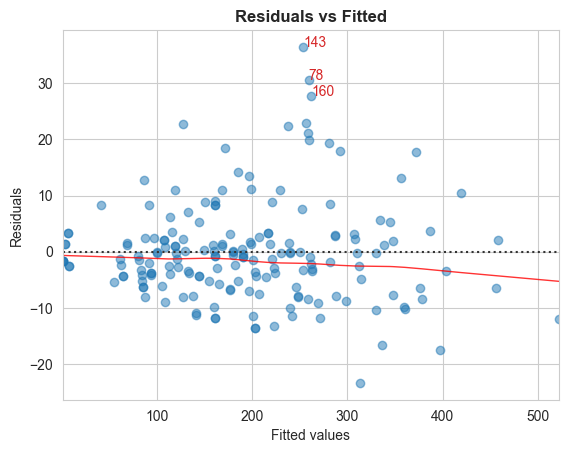

In [83]:
lm3_rd.residual_plot();

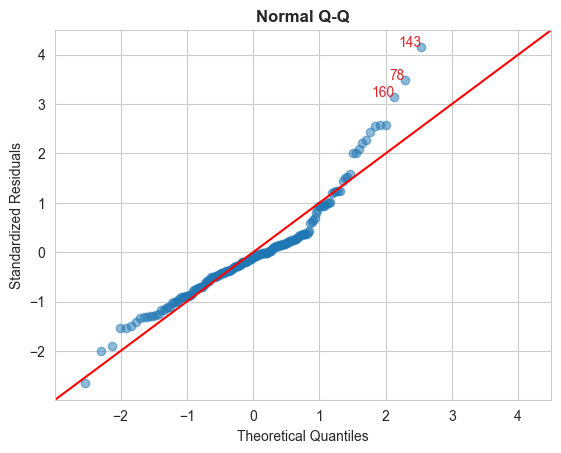

In [84]:
lm3_rd.qq_plot();

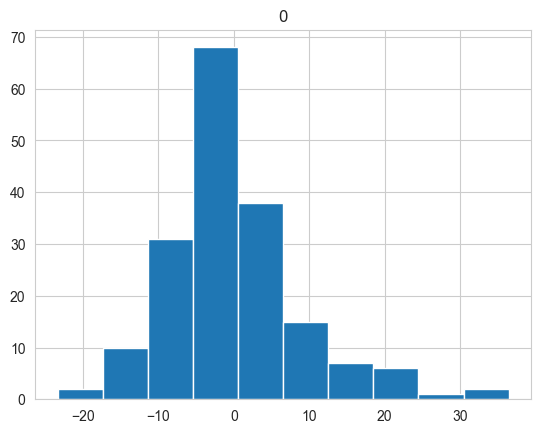

In [85]:
lm3_residuals_df = pd.DataFrame(lm3_rd.residual)
lm3_residuals_df.hist();

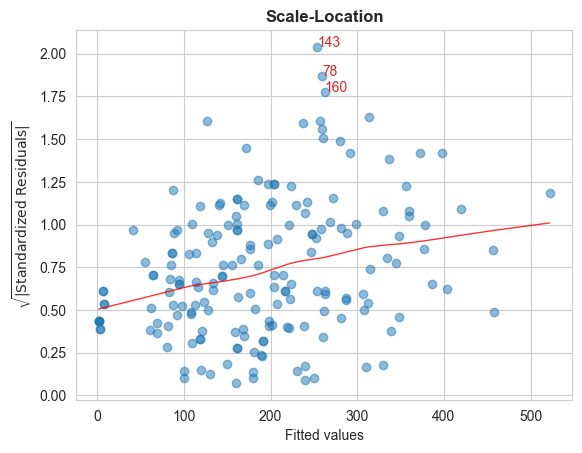

In [86]:
lm3_rd.scale_location_plot();

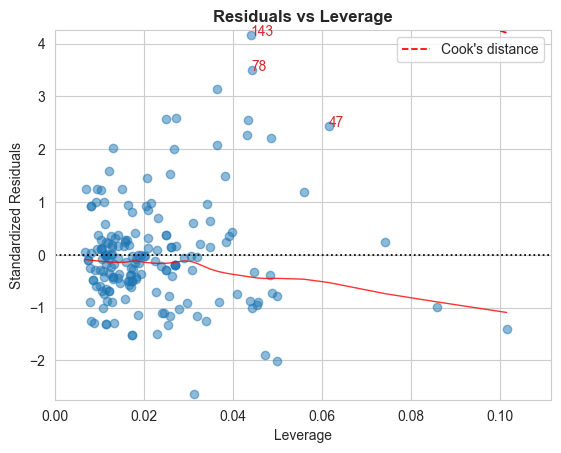

In [87]:
lm3_rd.leverage_plot();

The diagnostic plots are somewhat worse that those for the simple linear regression model. Considering that homogeneity of variance is questionable, it would be better to either opt for another, more robust regression method or transform the variables (e.g., replace the variables with their squared root or inverse values). However, for the sake of demonstrating the whole model building and evaluation process, we will proceed with the prediction on the test set.

In [88]:
X_test = sm.add_constant(X_test).drop(columns=['carbohydrates_tot'])
lm3_pred = lm3.get_prediction(X_test)
lm3_pred.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
26,353.782657,2.035953,349.764634,357.800679,335.639402,371.925911
185,241.662334,1.144698,239.403233,243.921436,223.825947,259.498722
5,98.052418,1.179728,95.724184,100.380652,80.207142,115.897693
211,308.116629,1.324620,305.502446,310.730811,290.231799,326.001458
7,109.172253,1.357256,106.493662,111.850844,91.277896,127.066611
...,...,...,...,...,...,...
83,452.141787,2.025945,448.143515,456.140059,434.002896,470.280678
39,254.070510,1.236651,251.629936,256.511083,236.210230,271.930789
141,198.866022,0.752350,197.381233,200.350811,181.111086,216.620959
28,104.163064,0.992464,102.204402,106.121727,86.362235,121.963894


In [90]:
# combine input variables and predictions into one data frame
df = lm3_pred.summary_frame().reset_index(drop=True)
X_test.reset_index(drop=True, inplace=True) 
 
lm3_pred_df = pd.concat([X_test, 
                         y_test.reset_index(drop=True), 
                         df['mean']], axis=1)
lm3_pred_df.rename(columns={'mean': 'calories_pred'}, inplace=True)
lm3_pred_df.head(10)

,const,fat_tot,sugar,proteins,calories,calories_pred
0,1.0,11.0,43,17.0,340,353.782657
1,1.0,3.0,50,3.0,240,241.662334
2,1.0,3.5,9,6.0,100,98.052418
3,1.0,4.0,62,5.0,310,308.116629
4,1.0,0.2,14,10.0,100,109.172253
5,1.0,1.5,17,7.0,110,117.414428
6,1.0,0.1,38,4.0,170,173.656931
7,1.0,0.0,0,1.0,15,6.679242
8,1.0,3.0,40,3.0,200,201.905595
9,1.0,1.5,36,15.0,270,233.030684


In [91]:
# confidence intervals
pd.concat([lm3_pred_df, df.mean_ci_lower, df.mean_ci_upper], axis=1)

,const,fat_tot,sugar,proteins,calories,calories_pred,mean_ci_lower,mean_ci_upper
0,1.0,11.0,43,17.0,340,353.782657,349.764634,357.800679
1,1.0,3.0,50,3.0,240,241.662334,239.403233,243.921436
2,1.0,3.5,9,6.0,100,98.052418,95.724184,100.380652
3,1.0,4.0,62,5.0,310,308.116629,305.502446,310.730811
4,1.0,0.2,14,10.0,100,109.172253,106.493662,111.850844
...,...,...,...,...,...,...,...,...
56,1.0,7.0,74,19.0,450,452.141787,448.143515,456.140059
57,1.0,7.0,33,12.0,270,254.070510,251.629936,256.511083
58,1.0,4.0,32,7.0,210,198.866022,197.381233,200.350811
59,1.0,0.1,18,6.0,100,104.163064,102.204402,106.121727


In [92]:
# prediction intervals
pd.concat([lm3_pred_df, df.obs_ci_lower, df.obs_ci_upper], axis=1)

,const,fat_tot,sugar,proteins,calories,calories_pred,obs_ci_lower,obs_ci_upper
0,1.0,11.0,43,17.0,340,353.782657,335.639402,371.925911
1,1.0,3.0,50,3.0,240,241.662334,223.825947,259.498722
2,1.0,3.5,9,6.0,100,98.052418,80.207142,115.897693
3,1.0,4.0,62,5.0,310,308.116629,290.231799,326.001458
4,1.0,0.2,14,10.0,100,109.172253,91.277896,127.066611
...,...,...,...,...,...,...,...,...
56,1.0,7.0,74,19.0,450,452.141787,434.002896,470.280678
57,1.0,7.0,33,12.0,270,254.070510,236.210230,271.930789
58,1.0,4.0,32,7.0,210,198.866022,181.111086,216.620959
59,1.0,0.1,18,6.0,100,104.163064,86.362235,121.963894


Prediction intervals are, again, fairly wide, but still far narrower compared to those for the simple lin. regression model.

Finally, compute evaluation measures:

In [93]:
lm3_eval = compute_eval_measures(y_train, 
                                 y_test.reset_index(drop=True), 
                                 lm3_pred_df.calories_pred)
print(f"R2 = {lm3_eval['R2']:.4f}")
print(f"RMSE = {lm3_eval['RMSE']:.4f}") 
print(f"RMSE / mean(calories_on_test_set) = {lm3_eval['RMSE']/mean(y_test):.4f}")

R2 = 0.9880
RMSE = 11.2031
RMSE / mean(calories_on_test_set) = 0.0570


Compare the performance of the latest model with the initial model:

In [94]:
pd.DataFrame.from_dict({'Model': ['LM1', 'LM3'],
                        'R2': [lm1_eval['R2'], lm3_eval['R2']],
                        'RMSE': [lm1_eval['RMSE'], lm3_eval['RMSE']]})

,Model,R2,RMSE
0,LM1,0.829900,42.222302
1,LM3,0.988024,11.203108


Obviously the latest model is much better than the initial one.

**Note**: 
Linear regression is not restricted to numerical variables; that is, a linear model can be built with categorical variables, as well, or a mix of numerical and categorical variables. However, model interpretation in that case is more difficult than when only numerical variables are used and thus is out of the scope of this course.